Test data EDA를 통해 train data와 test data의 양상을 파악해보자 

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from skimage import measure
import random


In [5]:
IMAGE_ROOT = '/data/ephemeral/home/data/test/DCM/'
OUTPUT_CSV_ROOT = '/data/ephemeral/home/mh/level2-cv-semanticsegmentation-cv-12-lv3/swin_unet_output_1.csv'
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]


In [6]:

def label2rgb(label):
    image_size = label.shape[1:] + (3,)
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

def decode_rle_to_mask(rle, height, width):
    if pd.isna(rle) or rle.strip() == "":
        return np.zeros((height, width), dtype=np.uint8)
    
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

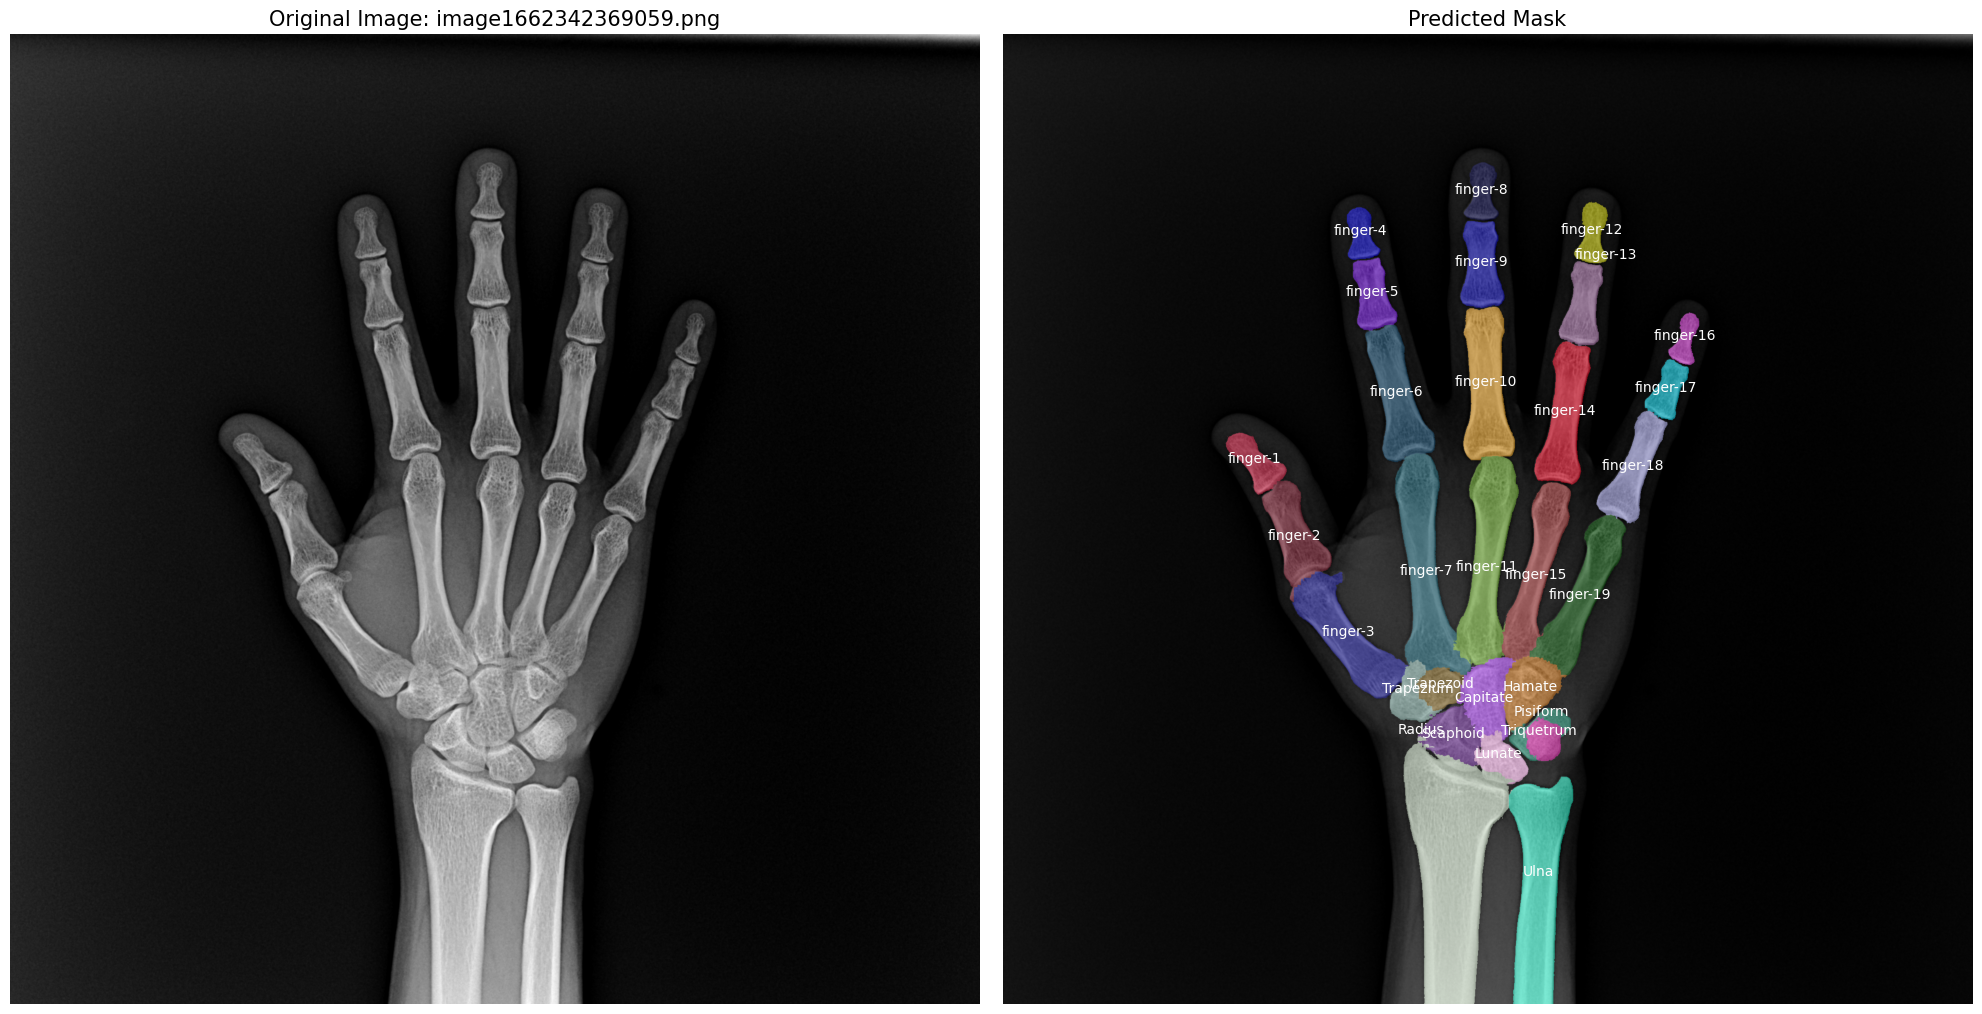

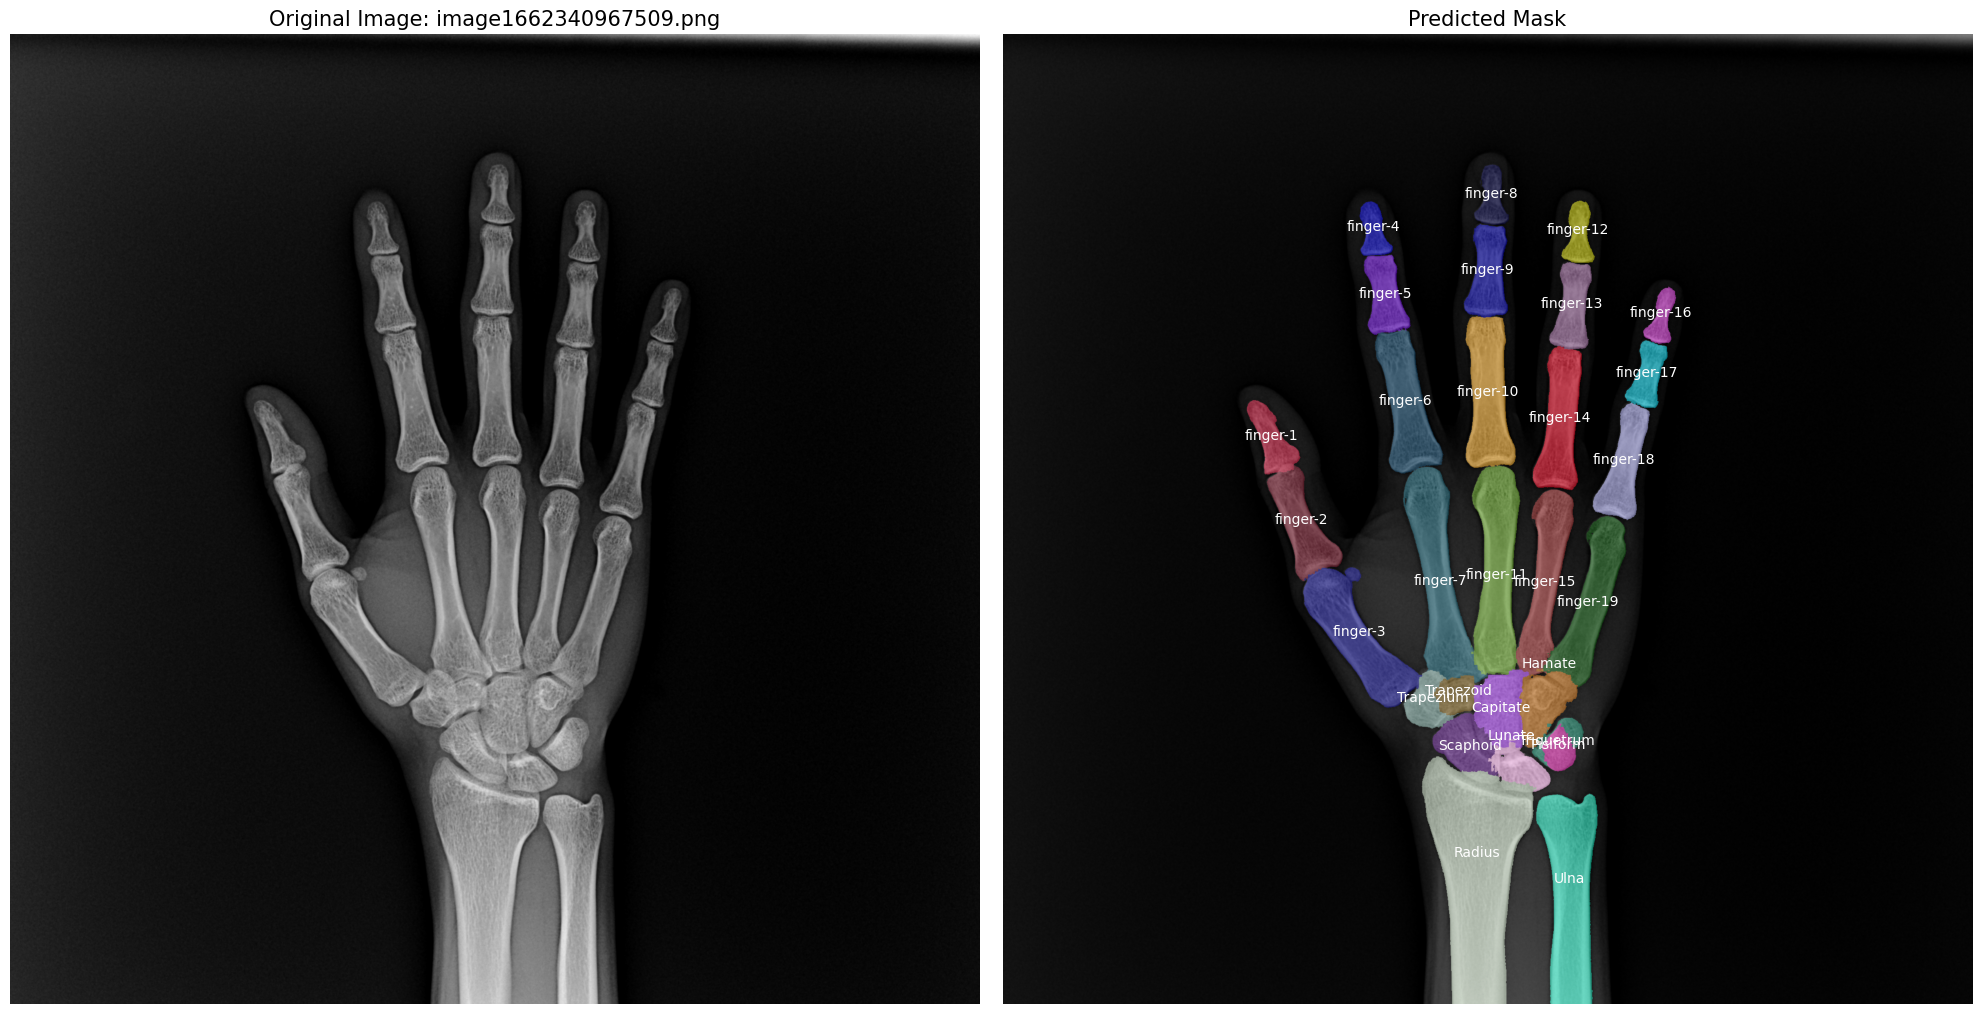

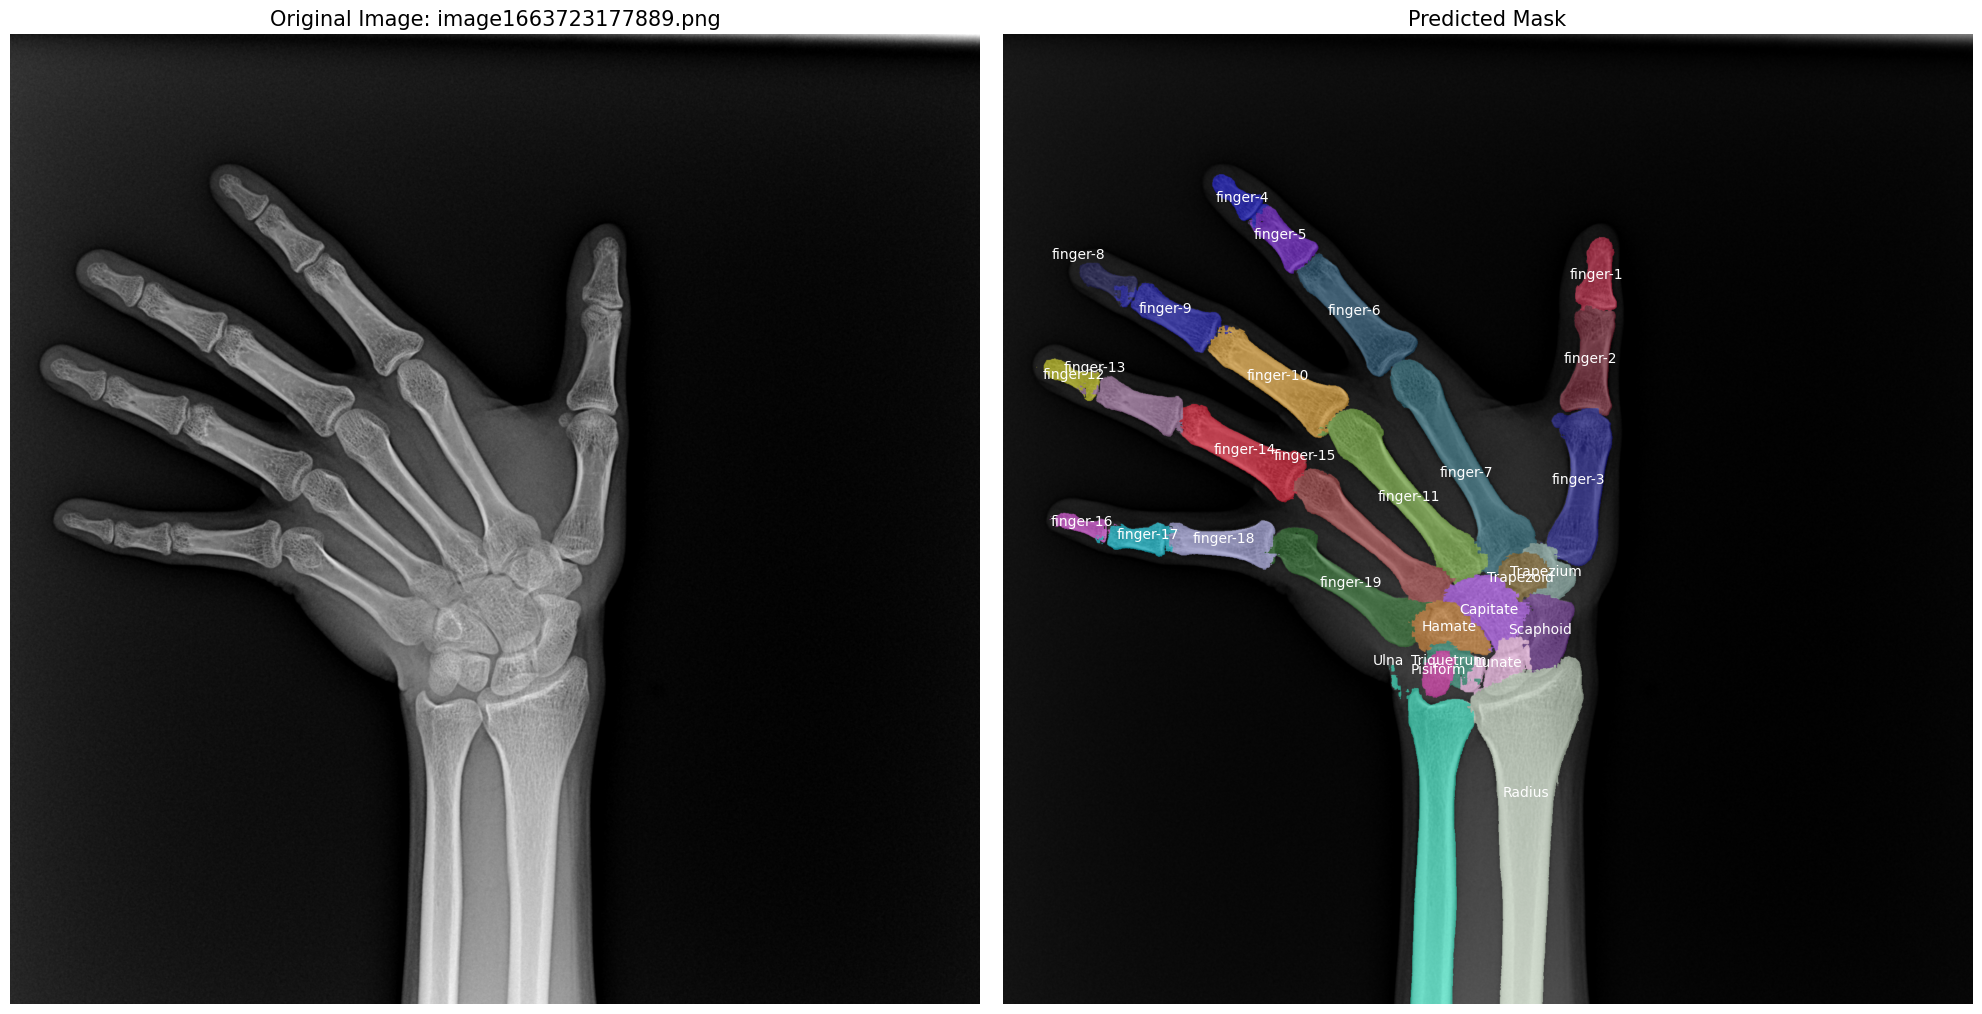

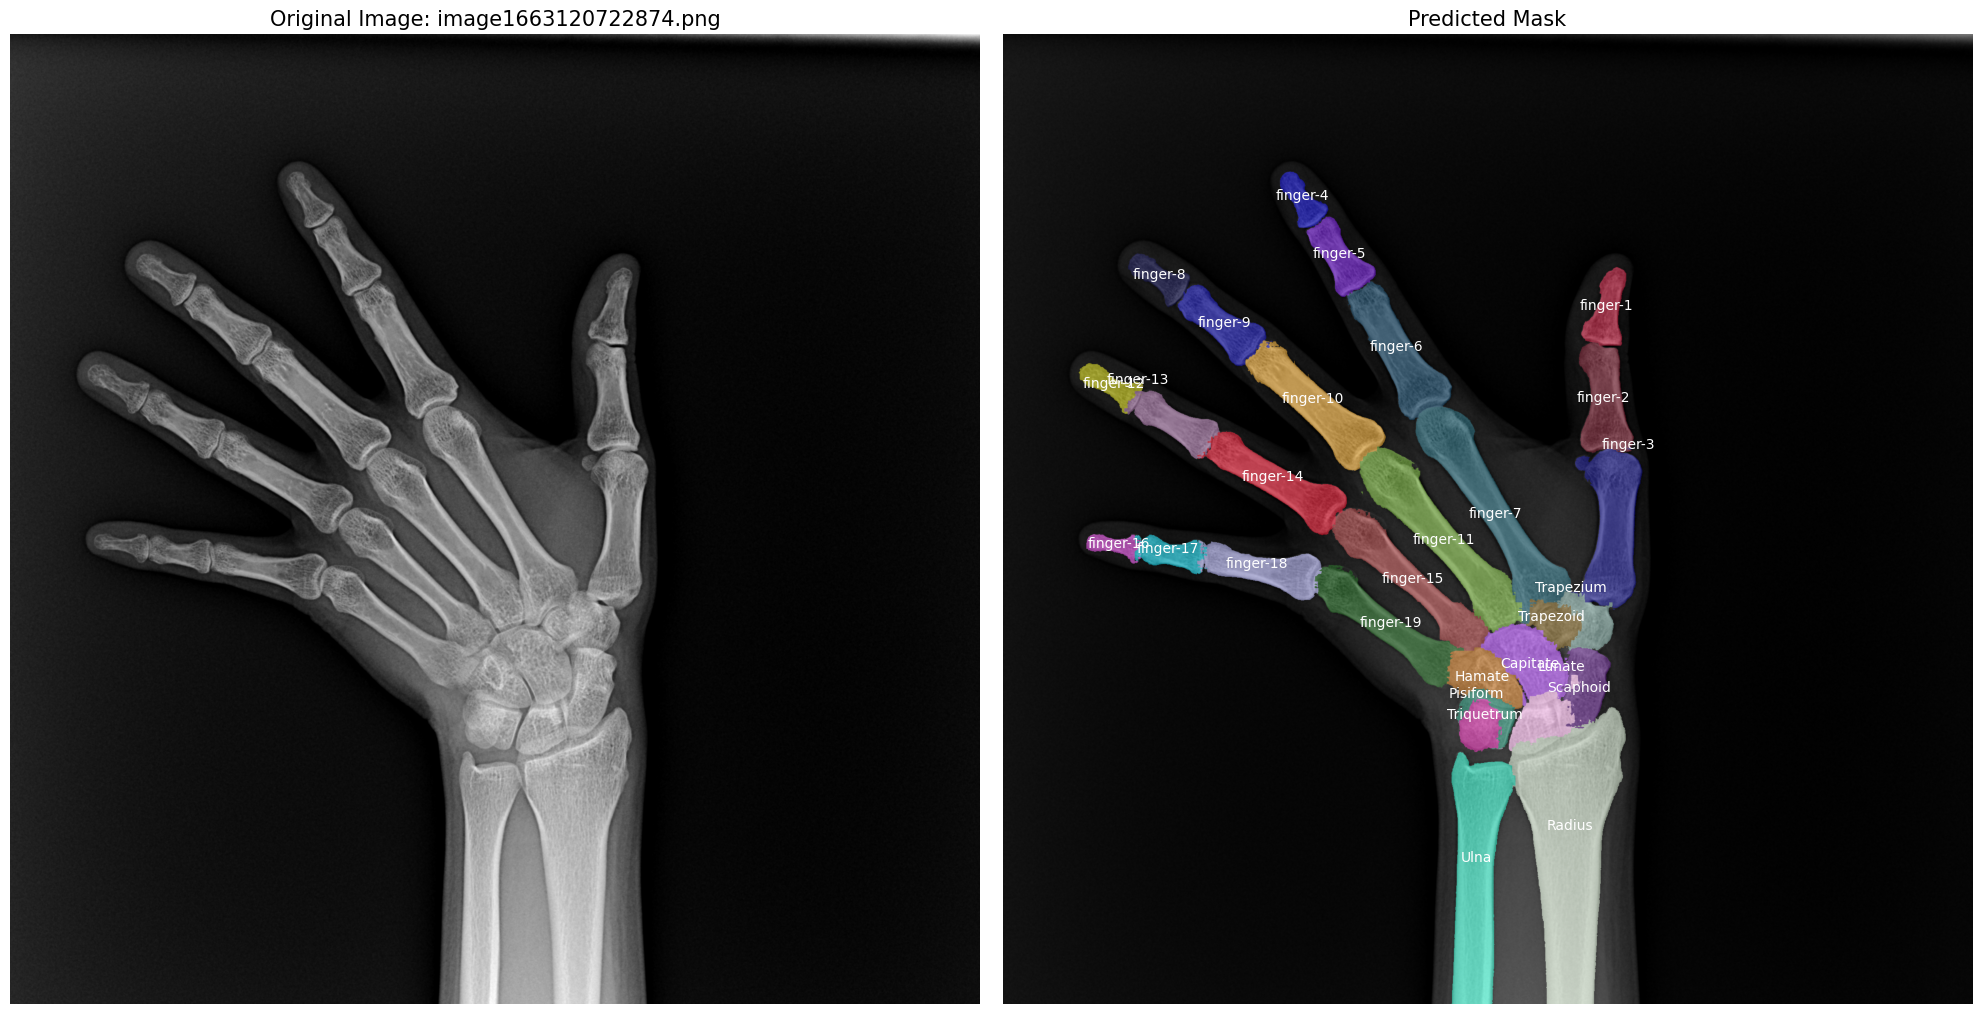

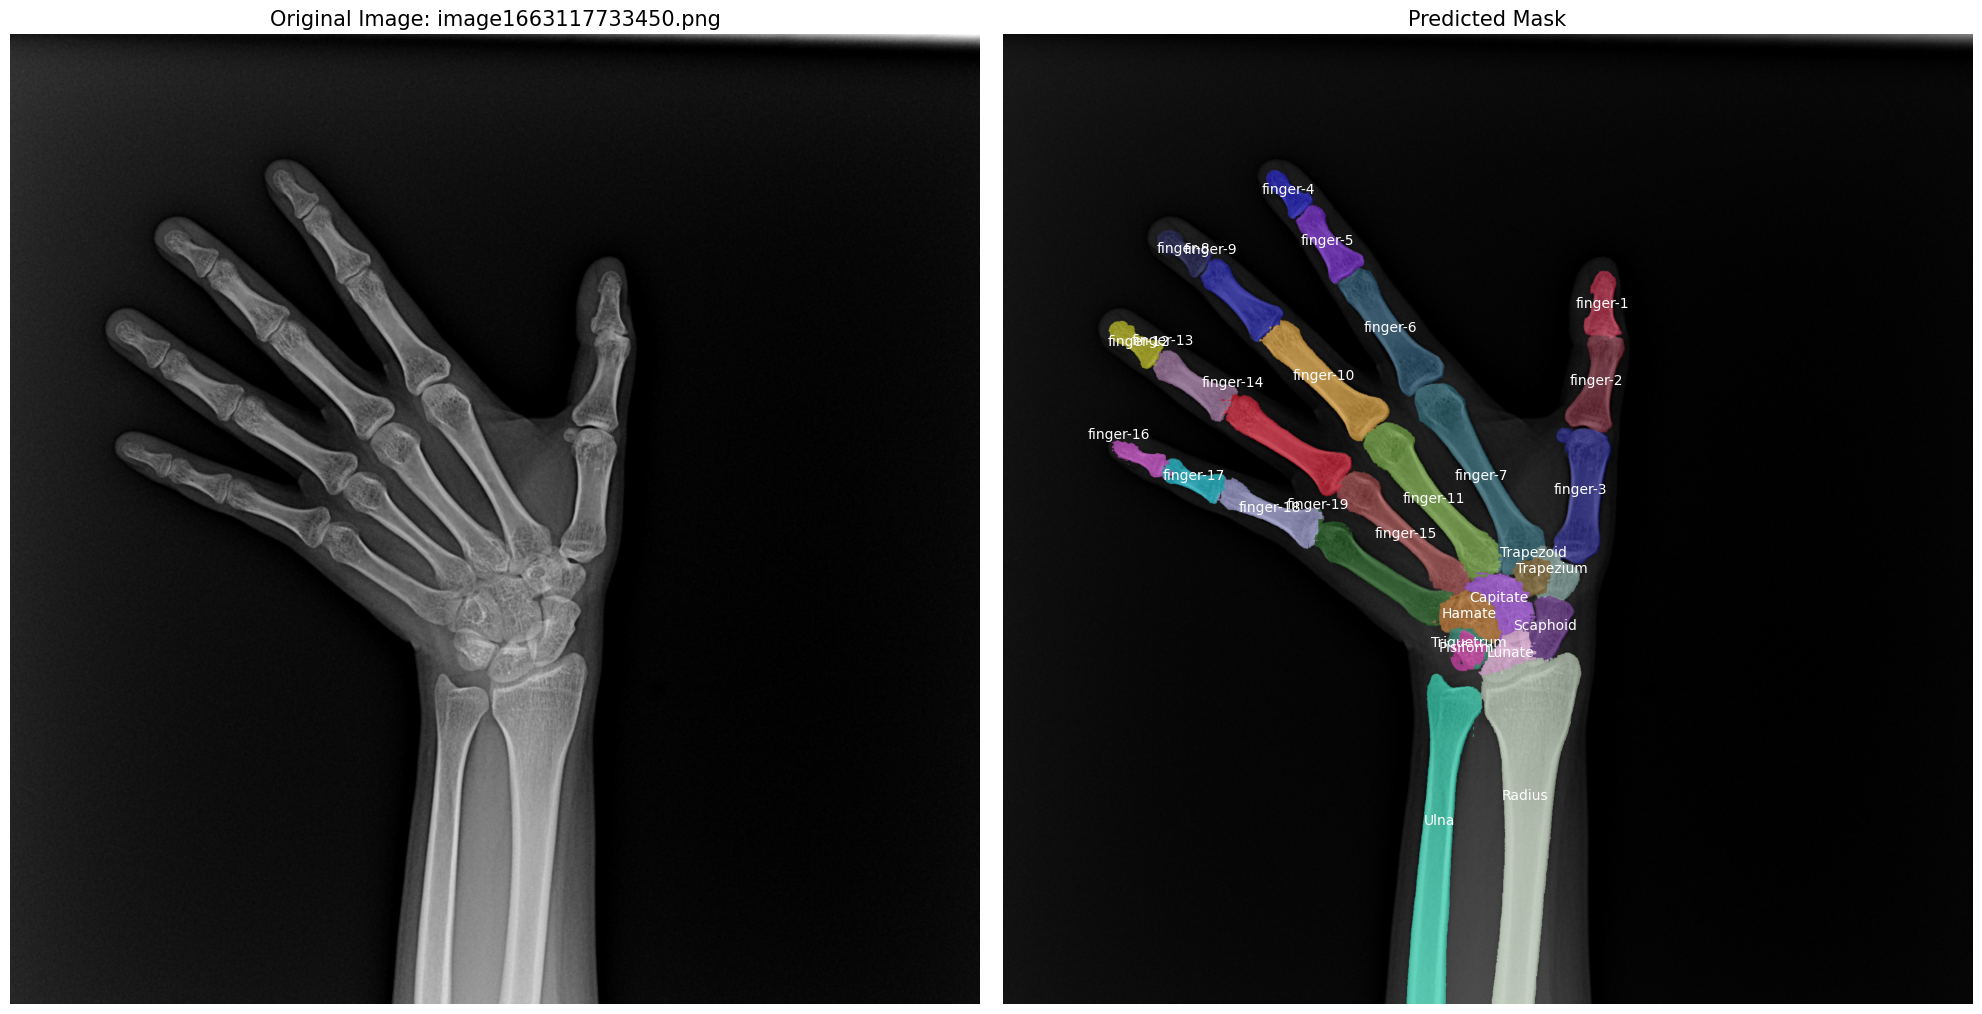

In [34]:
# Image path를 dictionary로 저장
image_dict = {}
for d in sorted(os.listdir(IMAGE_ROOT)):
    for f in sorted(os.listdir(os.path.join(IMAGE_ROOT, d))):
        image_dict[f] = os.path.join(IMAGE_ROOT, d, f)

# CSV 파일 읽기
df = pd.read_csv(OUTPUT_CSV_ROOT)

# 총 이미지 개수
num_images = len(df) // len(CLASSES)

# 랜덤으로 5개의 인덱스 선택
random_indices = random.sample(range(num_images), 5)

# 선택된 이미지만 시각화
for i in random_indices:
    preds = []
    
    # RLE 디코딩 및 마스크 생성
    for rle in df['rle'][i * len(CLASSES):(i + 1) * len(CLASSES)]:
        pred = decode_rle_to_mask(rle, height=2048, width=2048)
        preds.append(pred)
    
    # 마스크 스택 및 색칠된 이미지 생성
    preds = np.stack(preds, 0)
    pred_img = label2rgb(preds)
    
    # 원본 이미지 읽기
    file_name = df['image_name'][i * len(CLASSES)]
    img_path = image_dict[file_name]
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(original_img)
    axes[0].set_title(f'Original Image: {file_name}', fontsize=15)
    axes[0].axis('off')

    axes[1].imshow(original_img)
    axes[1].imshow(pred_img, alpha=0.5)
    axes[1].set_title('Predicted Mask', fontsize=15)
    axes[1].axis('off')
    
    # 각 클래스 레이블 추가
    for idx, rle in enumerate(df['rle'][i * len(CLASSES):(i + 1) * len(CLASSES)]):
        decoded_mask = decode_rle_to_mask(rle, 2048, 2048)
        if np.sum(decoded_mask) == 0:
            continue
        
        contours = measure.find_contours(decoded_mask, 0.5)
        if len(contours) > 0:
            contours = contours[0]
            contours = np.flip(contours, axis=1)
            
            # 중심점 계산 및 레이블 추가
            cx, cy = np.mean(contours, axis=0).astype(int)
            axes[1].text(cx, cy, CLASSES[idx], fontsize=10, color='white', fontweight='light', ha='center')

    plt.tight_layout()
    plt.show()

Randomly selected file: image1663722769493.png
Class: finger-1, Angle: 94.99°
Class: finger-2, Angle: 98.90°
Class: finger-3, Angle: 99.76°
Class: finger-4, Angle: 124.35°
Class: finger-5, Angle: 124.35°
Class: finger-6, Angle: 122.98°
Class: finger-7, Angle: 103.91°
Class: finger-8, Angle: 130.48°
Class: finger-9, Angle: 131.05°
Class: finger-10, Angle: 136.23°
Class: finger-11, Angle: 129.81°
Class: finger-12, Angle: 132.94°
Class: finger-13, Angle: 141.34°
Class: finger-14, Angle: 143.68°
Class: finger-15, Angle: 137.05°
Class: finger-16, Angle: 111.80°
Class: finger-17, Angle: 148.88°
Class: finger-18, Angle: 153.34°
Class: finger-19, Angle: 152.23°

Average Angle for all fingers: 127.27°


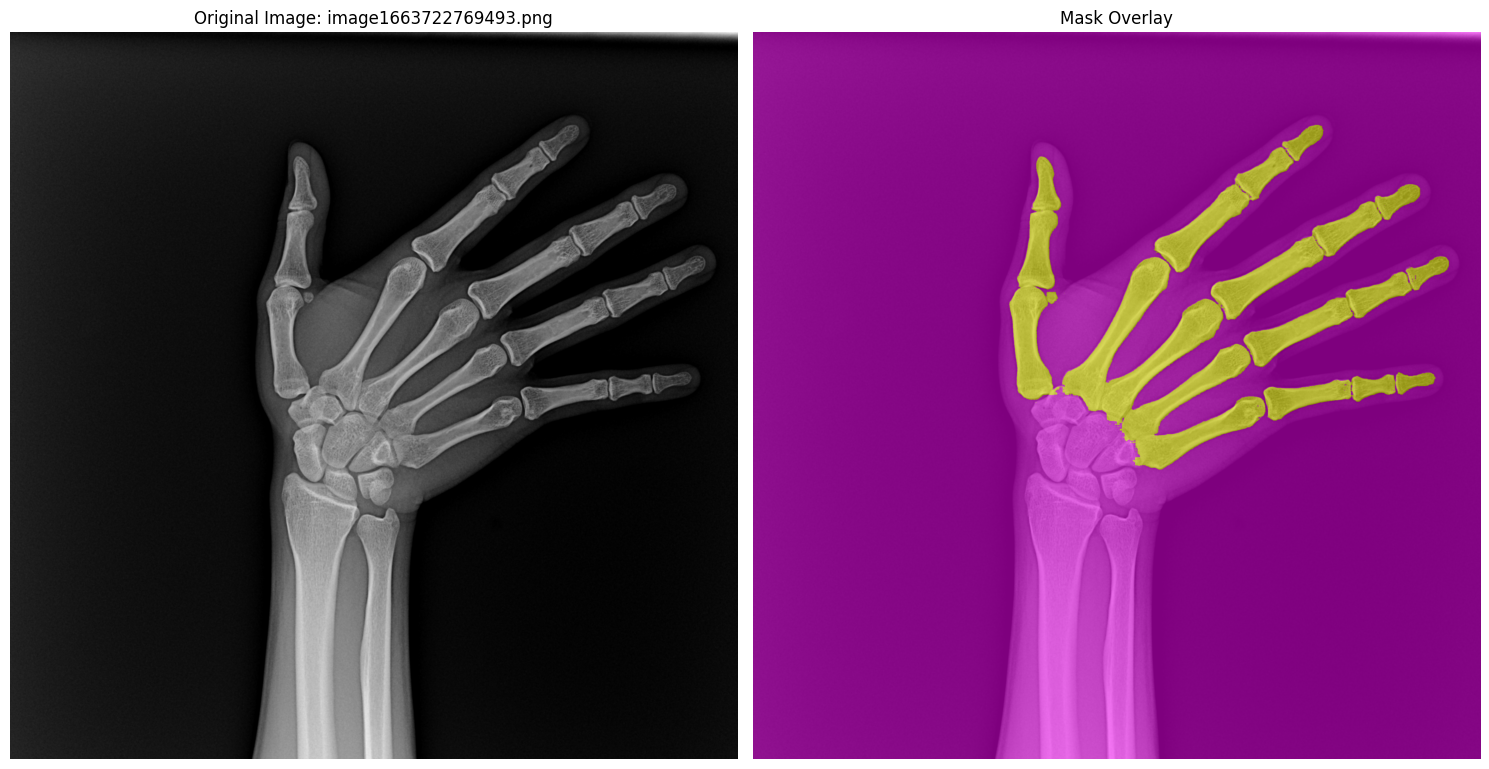

In [30]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import random

# RLE를 디코딩하여 마스크로 변환하는 함수
def decode_rle_to_mask(rle, height, width):
    if pd.isna(rle) or rle.strip() == "":
        return np.zeros((height, width), dtype=np.uint8)
    
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

# Skeletonization 및 기울기 계산 함수
def calculate_skeleton_angle(mask):
    skeleton = skeletonize(mask > 0)
    y_coords, x_coords = np.where(skeleton)
    
    if len(x_coords) < 2:
        return None
    
    # 시작점과 끝점 추출
    start_point = (x_coords[0], y_coords[0])
    end_point = (x_coords[-1], y_coords[-1])
    
    # 기울기 계산
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    angle = np.arctan2(dy, dx) * 180 / np.pi  # 라디안을 각도로 변환
    
    return angle

# finger 클래스의 기울기 출력 및 평균 기울기 계산
def calculate_angles_for_random_image(df, image_dict):
    finger_angles = []

    # 랜덤으로 하나의 파일 선택
    random_file = random.choice(list(image_dict.keys()))
    print(f"Randomly selected file: {random_file}")

    # CSV에서 해당 파일명을 기준으로 필터링
    filtered_df = df[df['image_name'] == random_file]

    if filtered_df.empty:
        print(f"No data found for file: {random_file}")
        return

    # 원본 이미지 불러오기
    img_path = image_dict[random_file]
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # 시각화 준비
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    axes[0].imshow(original_img)
    axes[0].set_title(f"Original Image: {random_file}")
    axes[0].axis('off')

    # 분석 결과 시각화
    mask_combined = np.zeros((2048, 2048), dtype=np.uint8)

    for cls in CLASSES:
        if not cls.startswith('finger'):
            continue
        
        # 해당 클래스에 대한 RLE 추출
        rle_row = filtered_df[filtered_df['class'] == cls]
        if rle_row.empty:
            continue
        
        rle = rle_row['rle'].values[0]
        mask = decode_rle_to_mask(rle, height=2048, width=2048)
        mask_combined = np.maximum(mask_combined, mask)

        # Skeletonization을 통한 기울기 계산
        angle = calculate_skeleton_angle(mask)
        
        # 기울기 값 출력
        if angle is not None:
            finger_angles.append(angle)
            print(f"Class: {cls}, Angle: {angle:.2f}°")

    # 마스크 시각화
    axes[1].imshow(original_img)
    axes[1].imshow(mask_combined, cmap='spring', alpha=0.5)
    axes[1].set_title("Mask Overlay")
    axes[1].axis('off')

    # 평균 기울기 출력
    if finger_angles:
        average_angle = np.mean(finger_angles)
        print(f"\nAverage Angle for all fingers: {average_angle:.2f}°")
    else:
        print("No valid angles found")

    plt.tight_layout()
    plt.show()

# 메인 코드
IMAGE_ROOT = '/data/ephemeral/home/data/test/DCM/'
OUTPUT_CSV_ROOT = '/data/ephemeral/home/mh/level2-cv-semanticsegmentation-cv-12-lv3/swin_unet_output_1.csv'

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna'
]

# Image path를 dictionary로 저장
image_dict = {}
for d in sorted(os.listdir(IMAGE_ROOT)):
    for f in sorted(os.listdir(os.path.join(IMAGE_ROOT, d))):
        image_dict[f] = os.path.join(IMAGE_ROOT, d, f)

# CSV 파일 읽기
df = pd.read_csv(OUTPUT_CSV_ROOT)
calculate_angles_for_random_image(df, image_dict)
